In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
import torch.optim as optim
import pytorch_lightning as pl
import copy
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print(device)

cuda:0


In [3]:
classes=['Covid','No Covid']

In [4]:
num_classes=2
batch_size=4

In [5]:
dataset = torchvision.datasets.ImageFolder(root="./data",transform=transforms.Compose([
                                                            transforms.ToTensor(),
                                                            transforms.Resize([227,227]),
#                                                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                                            ]))

In [6]:
print(len(dataset))
trainset,testset=torch.utils.data.random_split(dataset,[round(0.8*len(dataset)),round(0.2*len(dataset))],generator=torch.Generator().manual_seed(42))
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

8088


In [7]:
def plot_img(img,normal=False):
    npimg=img.numpy()
    if normal:
#     img*mean(0.5) + SD(0.5) => unnormalizing the image
        npimg=img.numpy()/2+0.5
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

In [8]:
%%notify -m "completed"
dataiter=iter(trainloader)
images,labels=dataiter.next()

<IPython.core.display.Javascript object>

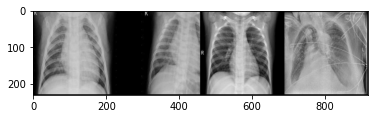

(None, ['No Covid', 'No Covid', 'No Covid', 'Covid'])

In [9]:
plot_img(torchvision.utils.make_grid(images)),list(map(lambda a: classes[a],labels))

## Extracting the Fully Connected Layer

In [10]:
# reshape all images to 64x64 and apply tensor transformation
dataset = torchvision.datasets.ImageFolder(root="./data",transform=transforms.Compose([
                                                            transforms.ToTensor(),
                                                            transforms.Resize([227,227]),
#                                                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                                            # transforms.Grayscale(num_output_channels=1)
                                                            ]))
# testset = torchvision.datasets.ImageFolder(root="./xray",train=False,transform=transforms.Compose([transforms.Resize([300,305]),transforms.ToTensor()]))
# testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

In [11]:
print(len(dataset))
trainset,testset=torch.utils.data.random_split(dataset,[round(0.8*len(dataset)),round(0.2*len(dataset))],generator=torch.Generator().manual_seed(42))
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

8088


In [12]:
def plot_img(img):
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

In [13]:
%%notify -m "completed"
dataiter=iter(trainloader)
images,labels=dataiter.next()
img=images[0]
print(type(img))
npimg=img.numpy()
print(npimg.shape)

<class 'torch.Tensor'>
(3, 227, 227)


<IPython.core.display.Javascript object>

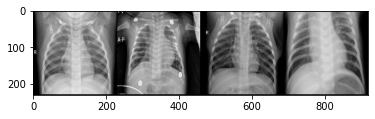

No Covid Covid No Covid Covid 

In [14]:
plot_img(torchvision.utils.make_grid(images))
for i in range(4):
    print(classes[labels[i]],end=" ")

In [15]:
def evaluation(dataloader,model):
    model.eval()
    with torch.no_grad():
        total,correct=0,0
        for data in dataloader:
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=model(inputs)
    #         print(outputs)
    #         print(outputs,labels)
            m = nn.Sigmoid()
            outputs=m(outputs)
            pred=outputs>=0.5
            pred=pred.flatten()
            total+=labels.size(0)
            # labels=torch.add(labels,-1)
            # print(pred,labels)
    #         print(list(map(lambda a: classes[a],pred)),list(map(lambda a: classes[a],labels)))
            correct+=(pred==labels).sum().item()
    print(correct,total)
    model.train()
    return 100*correct/total

In [16]:
class CNN(nn.Module):
    def get_first_FC_Layer(self,x):
        x=self.representation_network(x).flatten(1)
        x=self.classification_network[0](x)
        return x;
    def get_Representation_Net(self,x):
        x=self.representation_network(x).flatten(1)
        return  x;
    def __init__(self):
        super(CNN,self).__init__()
        self.representation_network=nn.Sequential(
            nn.Conv2d(3,128,5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128,64,3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,32,3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.classification_network=nn.Sequential(
            nn.Linear(21632,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,1),
#             nn.Sigmoid()
        )
    def forward(self,x):
        # print(x.shape)
        x=self.representation_network(x)
#         print(x.shape)
        # flattening of the vector=> same dimension of first index(batch size) , everythign else is flattened(-1)
        x=x.view(x.size(0),-1)
#         print(x.shape)
        x=self.classification_network(x)
        # print(x.shape)
        return x

In [46]:
net = CNN()
net.load_state_dict(torch.load("Second_CNN_final.pth").state_dict())
# net=net.to(device)

<All keys matched successfully>

### Getting The Fully connected layer

In [18]:
%%notify -m "Completed"

X_Train=np.empty((0,512))
Y_Train=np.empty((0,batch_size))
print(X_Train.shape)
for i,data in enumerate(trainloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    FCLayer=net.get_first_FC_Layer(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Train=np.append(X_Train,FCLayer,axis=0)
    Y_Train=np.append(Y_Train,labels.numpy())
print(X_Train.shape,Y_Train.shape)

(0, 512)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the bat

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


Done with the batch: 660
Done with the batch: 661
Done with the batch: 662
Done with the batch: 663
Done with the batch: 664
Done with the batch: 665
Done with the batch: 666
Done with the batch: 667
Done with the batch: 668
Done with the batch: 669
Done with the batch: 670
Done with the batch: 671
Done with the batch: 672
Done with the batch: 673
Done with the batch: 674
Done with the batch: 675
Done with the batch: 676
Done with the batch: 677
Done with the batch: 678
Done with the batch: 679
Done with the batch: 680
Done with the batch: 681
Done with the batch: 682
Done with the batch: 683
Done with the batch: 684
Done with the batch: 685
Done with the batch: 686
Done with the batch: 687
Done with the batch: 688
Done with the batch: 689
Done with the batch: 690
Done with the batch: 691
Done with the batch: 692
Done with the batch: 693
Done with the batch: 694
Done with the batch: 695
Done with the batch: 696
Done with the batch: 697
Done with the batch: 698
Done with the batch: 699


Done with the batch: 988
Done with the batch: 989
Done with the batch: 990
Done with the batch: 991
Done with the batch: 992
Done with the batch: 993
Done with the batch: 994
Done with the batch: 995
Done with the batch: 996
Done with the batch: 997
Done with the batch: 998
Done with the batch: 999
Done with the batch: 1000
Done with the batch: 1001
Done with the batch: 1002
Done with the batch: 1003
Done with the batch: 1004
Done with the batch: 1005
Done with the batch: 1006
Done with the batch: 1007
Done with the batch: 1008
Done with the batch: 1009
Done with the batch: 1010
Done with the batch: 1011
Done with the batch: 1012
Done with the batch: 1013
Done with the batch: 1014
Done with the batch: 1015
Done with the batch: 1016
Done with the batch: 1017
Done with the batch: 1018
Done with the batch: 1019
Done with the batch: 1020
Done with the batch: 1021
Done with the batch: 1022
Done with the batch: 1023
Done with the batch: 1024
Done with the batch: 1025
Done with the batch: 102

Done with the batch: 1304
Done with the batch: 1305
Done with the batch: 1306
Done with the batch: 1307
Done with the batch: 1308
Done with the batch: 1309
Done with the batch: 1310
Done with the batch: 1311
Done with the batch: 1312
Done with the batch: 1313
Done with the batch: 1314
Done with the batch: 1315
Done with the batch: 1316
Done with the batch: 1317
Done with the batch: 1318
Done with the batch: 1319
Done with the batch: 1320
Done with the batch: 1321
Done with the batch: 1322
Done with the batch: 1323
Done with the batch: 1324
Done with the batch: 1325
Done with the batch: 1326
Done with the batch: 1327
Done with the batch: 1328
Done with the batch: 1329
Done with the batch: 1330
Done with the batch: 1331
Done with the batch: 1332
Done with the batch: 1333
Done with the batch: 1334
Done with the batch: 1335
Done with the batch: 1336
Done with the batch: 1337
Done with the batch: 1338
Done with the batch: 1339
Done with the batch: 1340
Done with the batch: 1341
Done with th

<IPython.core.display.Javascript object>

In [19]:
%%notify -m "Completed"
X_Test=np.empty((0,512))
Y_Test=np.empty((0,batch_size))
print(X_Test.shape)
for i,data in enumerate(testloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    FCLayer=net.get_first_FC_Layer(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Test=np.append(X_Test,FCLayer,axis=0)
    Y_Test=np.append(Y_Test,labels.numpy())
print(X_Test.shape,Y_Test.shape)

(0, 512)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the bat

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


<IPython.core.display.Javascript object>

## Getting the Feature Map

In [20]:
%%notify -m "Completed"
X_Train_FeatureMap=np.empty((0,21632))
Y_Train_FeatureMap=np.empty((0,batch_size))
print(X_Train_FeatureMap.shape)
for i,data in enumerate(trainloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    featureMap=net.get_Representation_Net(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Train_FeatureMap=np.append(X_Train_FeatureMap,featureMap,axis=0)
    Y_Train_FeatureMap=np.append(Y_Train_FeatureMap,labels.numpy())
print(X_Train_FeatureMap.shape,Y_Train_FeatureMap.shape)

(0, 21632)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the b

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


Done with the batch: 660
Done with the batch: 661
Done with the batch: 662
Done with the batch: 663
Done with the batch: 664
Done with the batch: 665
Done with the batch: 666
Done with the batch: 667
Done with the batch: 668
Done with the batch: 669
Done with the batch: 670
Done with the batch: 671
Done with the batch: 672
Done with the batch: 673
Done with the batch: 674
Done with the batch: 675
Done with the batch: 676
Done with the batch: 677
Done with the batch: 678
Done with the batch: 679
Done with the batch: 680
Done with the batch: 681
Done with the batch: 682
Done with the batch: 683
Done with the batch: 684
Done with the batch: 685
Done with the batch: 686
Done with the batch: 687
Done with the batch: 688
Done with the batch: 689
Done with the batch: 690
Done with the batch: 691
Done with the batch: 692
Done with the batch: 693
Done with the batch: 694
Done with the batch: 695
Done with the batch: 696
Done with the batch: 697
Done with the batch: 698
Done with the batch: 699


Done with the batch: 988
Done with the batch: 989
Done with the batch: 990
Done with the batch: 991
Done with the batch: 992
Done with the batch: 993
Done with the batch: 994
Done with the batch: 995
Done with the batch: 996
Done with the batch: 997
Done with the batch: 998
Done with the batch: 999
Done with the batch: 1000
Done with the batch: 1001
Done with the batch: 1002
Done with the batch: 1003
Done with the batch: 1004
Done with the batch: 1005
Done with the batch: 1006
Done with the batch: 1007
Done with the batch: 1008
Done with the batch: 1009
Done with the batch: 1010
Done with the batch: 1011
Done with the batch: 1012
Done with the batch: 1013
Done with the batch: 1014
Done with the batch: 1015
Done with the batch: 1016
Done with the batch: 1017
Done with the batch: 1018
Done with the batch: 1019
Done with the batch: 1020
Done with the batch: 1021
Done with the batch: 1022
Done with the batch: 1023
Done with the batch: 1024
Done with the batch: 1025
Done with the batch: 102

Done with the batch: 1304
Done with the batch: 1305
Done with the batch: 1306
Done with the batch: 1307
Done with the batch: 1308
Done with the batch: 1309
Done with the batch: 1310
Done with the batch: 1311
Done with the batch: 1312
Done with the batch: 1313
Done with the batch: 1314
Done with the batch: 1315
Done with the batch: 1316
Done with the batch: 1317
Done with the batch: 1318
Done with the batch: 1319
Done with the batch: 1320
Done with the batch: 1321
Done with the batch: 1322
Done with the batch: 1323
Done with the batch: 1324
Done with the batch: 1325
Done with the batch: 1326
Done with the batch: 1327
Done with the batch: 1328
Done with the batch: 1329
Done with the batch: 1330
Done with the batch: 1331
Done with the batch: 1332
Done with the batch: 1333
Done with the batch: 1334
Done with the batch: 1335
Done with the batch: 1336
Done with the batch: 1337
Done with the batch: 1338
Done with the batch: 1339
Done with the batch: 1340
Done with the batch: 1341
Done with th

<IPython.core.display.Javascript object>

In [21]:
%%notify -m "Completed"
X_Test_FeatureMap=np.empty((0,21632))
Y_Test_FeatureMap=np.empty((0,batch_size))
print(X_Test_FeatureMap.shape)
for i,data in enumerate(testloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    featuremap=net.get_Representation_Net(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Test_FeatureMap=np.append(X_Test_FeatureMap,featuremap,axis=0)
    Y_Test_FeatureMap=np.append(Y_Test_FeatureMap,labels.numpy())
print(X_Test_FeatureMap.shape,Y_Test_FeatureMap.shape)

(0, 21632)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the b

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


<IPython.core.display.Javascript object>

## SVM

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,f1_score,roc_auc_score,recall_score
from sklearn.model_selection import KFold

In [52]:
def k_fold_cv_svm(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
#         clf=SVC(C=10,kernel='rbf',gamma=0.00001)
        clf=SVC(C=10,kernel='rbf',gamma=10)
        clf.fit(X_train,y_train.ravel())
        y_pred = clf.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del clf
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return clf

In [60]:
tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-2,0.1,1,10],
                     'C': [0.001,0.1,1, 10, 100],
}
# tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3],
#                      'C': [0.001],
#                    }
clf = GridSearchCV(
        SVC(), tuned_parameters, scoring= 'accuracy',verbose=10
    )
clf.fit(X_Train, Y_Train.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 1/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.501 total time=   9.7s
[CV 2/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 2/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.502 total time=  10.2s
[CV 3/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 3/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.502 total time=  10.8s
[CV 4/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 4/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.502 total time=  10.4s
[CV 5/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 5/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.502 total time=  13.8s
[CV 1/5; 2/25] START C=0.001, gamma=0.01, kernel=rbf............................
[CV 1/5; 2/25] END C=0.001,

[CV 1/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.642 total time=  12.6s
[CV 2/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 2/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.643 total time=  12.6s
[CV 3/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 3/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.648 total time=  12.6s
[CV 4/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 4/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.645 total time=  12.7s
[CV 5/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 5/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.657 total time=  12.8s
[CV 1/5; 12/25] START C=1, gamma=0.01, kernel=rbf...............................
[CV 1/5; 12/25] END C=1, gamma=0.01, kernel=rbf;, score=0.594 total time=  14.5s
[CV 2/5; 12/25] START C=1, gamma=0.01, kernel=rbf...............................
[CV 2/5; 12/25] END C=1

[CV 2/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.651 total time=  13.1s
[CV 3/5; 21/25] START C=100, gamma=0.001, kernel=rbf............................
[CV 3/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.650 total time=  12.2s
[CV 4/5; 21/25] START C=100, gamma=0.001, kernel=rbf............................
[CV 4/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.649 total time=  12.8s
[CV 5/5; 21/25] START C=100, gamma=0.001, kernel=rbf............................
[CV 5/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.661 total time=  12.9s
[CV 1/5; 22/25] START C=100, gamma=0.01, kernel=rbf.............................
[CV 1/5; 22/25] END C=100, gamma=0.01, kernel=rbf;, score=0.594 total time=  14.1s
[CV 2/5; 22/25] START C=100, gamma=0.01, kernel=rbf.............................
[CV 2/5; 22/25] END C=100, gamma=0.01, kernel=rbf;, score=0.598 total time=  14.6s
[CV 3/5; 22/25] START C=100, gamma=0.01, kernel=rbf.............................
[CV 3/5; 22/

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=10)

In [34]:
clf=k_fold_cv_svm(X_Train,Y_Train.ravel())
clf=SVC(C=10,kernel='rbf',gamma=0.00001)
clf.fit(X_Train,Y_Train.ravel())
y_pred=clf.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 96.44513137557959
FOLD 1
--------------------------------
Accuracy: 96.36785162287481
FOLD 2
--------------------------------
Accuracy: 95.5177743431221
FOLD 3
--------------------------------
Accuracy: 96.44513137557959
FOLD 4
--------------------------------
Accuracy: 96.44513137557959
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 96.44513137557959 %
Fold 1: 96.36785162287481 %
Fold 2: 95.5177743431221 %
Fold 3: 96.44513137557959 %
Fold 4: 96.44513137557959 %
Average: 96.24420401854714 %
Accuracy:  0.9177997527812114
F1-Score:  0.9195402298850575
Precision:  0.9101796407185628
Recall:  0.9290953545232273
AUC:  0.9176726772616137


## Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
def k_fold_cv_dtree(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        decision_tree = DecisionTreeClassifier(random_state=102)
        decision_tree = decision_tree.fit(X_train, y_train.ravel())
        y_pred = decision_tree.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del decision_tree
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return decision_tree

In [37]:
dtree=k_fold_cv_dtree(X_Train,Y_Train.ravel())
dtree=DecisionTreeClassifier(random_state=102)
dtree=dtree.fit(X_Train,Y_Train.ravel())
y_pred=dtree.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 93.81761978361669
FOLD 1
--------------------------------
Accuracy: 93.12210200927356
FOLD 2
--------------------------------
Accuracy: 92.96754250386398
FOLD 3
--------------------------------
Accuracy: 94.20401854714065
FOLD 4
--------------------------------
Accuracy: 93.35394126738794
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 93.81761978361669 %
Fold 1: 93.12210200927356 %
Fold 2: 92.96754250386398 %
Fold 3: 94.20401854714065 %
Fold 4: 93.35394126738794 %
Average: 93.49304482225656 %
Accuracy:  0.8800988875154512
F1-Score:  0.8827085852478839
Precision:  0.8732057416267942
Recall:  0.8924205378973105
AUC:  0.8799602689486552


## RandomForest

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
def k_fold_cv_rforest(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        random_forest = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=102)
        random_forest = random_forest.fit(X_train, y_train.ravel())
        y_pred = random_forest.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del random_forest
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return random_forest

In [47]:
random_forest=k_fold_cv_rforest(X_Train,Y_Train.ravel())
random_forest=RandomForestClassifier(n_estimators=100,criterion='gini',random_state=102)
random_forest = random_forest.fit(X_Train, Y_Train.ravel())
y_pred=random_forest.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 96.59969088098919
FOLD 1
--------------------------------
Accuracy: 95.6723338485317
FOLD 2
--------------------------------
Accuracy: 96.52241112828439
FOLD 3
--------------------------------
Accuracy: 95.28593508500772
FOLD 4
--------------------------------
Accuracy: 96.21329211746522
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 96.59969088098919 %
Fold 1: 95.6723338485317 %
Fold 2: 96.52241112828439 %
Fold 3: 95.28593508500772 %
Fold 4: 96.21329211746522 %
Average: 96.05873261205564 %
Accuracy:  0.9091470951792336
F1-Score:  0.9118176364727055
Precision:  0.8951707891637221
Recall:  0.9290953545232273
AUC:  0.9089226772616137


## XGBOOST

In [43]:
import xgboost as xgb

In [44]:
def k_fold_cv_xgb(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        eval_set = [(X_train, y_train.ravel()), (X_test, y_test)]
        xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=102,use_label_encoder=False)
        xg_cl.fit(X_train,y_train.ravel())
        y_pred = xg_cl.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del xg_cl
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return xg_cl

In [45]:
xg=k_fold_cv_xgb(X_Train,Y_Train.ravel())
xg = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=102,use_label_encoder=False)
xg.fit(X_Train,Y_Train.ravel())
y_pred=xg.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test.ravel(),y_pred))

FOLD 0
--------------------------------
[21:48:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 97.2952086553323
FOLD 1
--------------------------------
[21:48:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 96.67697063369397
FOLD 2
--------------------------------
[21:49:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was 

## MLP

In [48]:
from sklearn.neural_network import MLPClassifier

In [49]:
def k_fold_cv_mlp(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        clf = MLPClassifier(random_state=102, max_iter=3000, verbose=True).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del clf
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return clf

In [51]:
clf=k_fold_cv_mlp(X_Train,Y_Train.ravel())
clf=MLPClassifier(random_state=102, max_iter=3000, verbose=True).fit(X_Train, Y_Train.ravel())
y_pred=clf.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test.ravel(),y_pred))

FOLD 0
--------------------------------
Iteration 1, loss = 2.28087899
Iteration 2, loss = 0.67371051
Iteration 3, loss = 0.41758177
Iteration 4, loss = 0.31237939
Iteration 5, loss = 0.23967766
Iteration 6, loss = 0.18801329
Iteration 7, loss = 0.21535327
Iteration 8, loss = 0.18667840
Iteration 9, loss = 0.14331392
Iteration 10, loss = 0.13066019
Iteration 11, loss = 0.11418375
Iteration 12, loss = 0.10480662
Iteration 13, loss = 0.10594987
Iteration 14, loss = 0.12059307
Iteration 15, loss = 0.08493516
Iteration 16, loss = 0.10752949
Iteration 17, loss = 0.08354693
Iteration 18, loss = 0.10781912
Iteration 19, loss = 0.08412448
Iteration 20, loss = 0.09774558
Iteration 21, loss = 0.08666175
Iteration 22, loss = 0.07765588
Iteration 23, loss = 0.08101555
Iteration 24, loss = 0.06857828
Iteration 25, loss = 0.07227568
Iteration 26, loss = 0.06889667
Iteration 27, loss = 0.06644075
Iteration 28, loss = 0.07732392
Iteration 29, loss = 0.17725637
Iteration 30, loss = 0.09082761
Iteration

Iteration 39, loss = 0.07853707
Iteration 40, loss = 0.07261595
Iteration 41, loss = 0.05254493
Iteration 42, loss = 0.05297970
Iteration 43, loss = 0.05200024
Iteration 44, loss = 0.06356983
Iteration 45, loss = 0.05398146
Iteration 46, loss = 0.06867221
Iteration 47, loss = 0.06461489
Iteration 48, loss = 0.05829684
Iteration 49, loss = 0.04682742
Iteration 50, loss = 0.06894951
Iteration 51, loss = 0.05569819
Iteration 52, loss = 0.05118140
Iteration 53, loss = 0.05807856
Iteration 54, loss = 0.05160062
Iteration 55, loss = 0.05433249
Iteration 56, loss = 0.04556092
Iteration 57, loss = 0.04027412
Iteration 58, loss = 0.03535938
Iteration 59, loss = 0.04437995
Iteration 60, loss = 0.04677492
Iteration 61, loss = 0.06961605
Iteration 62, loss = 0.05852958
Iteration 63, loss = 0.05152260
Iteration 64, loss = 0.04927967
Iteration 65, loss = 0.04875537
Iteration 66, loss = 0.04748034
Iteration 67, loss = 0.04284238
Iteration 68, loss = 0.04308503
Iteration 69, loss = 0.06228622
Training

## PCA

In [54]:
from sklearn.decomposition import KernelPCA

Text(0, 0.5, 'cumulative explained variance')

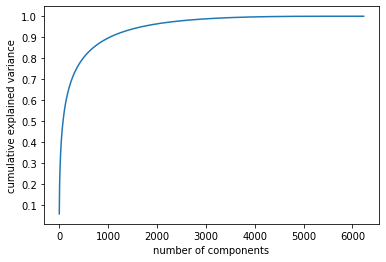

In [24]:
kpca = KernelPCA(kernel = 'rbf')
kpca_transform = kpca.fit_transform(X_Train_FeatureMap)
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [55]:
kpca = KernelPCA(kernel = 'rbf',n_components=4000)
X_Train_Transformed_FeatureMap = kpca.fit_transform(X_Train_FeatureMap)
print(X_Train_Transformed_FeatureMap.shape)

(6470, 4000)


In [56]:
X_Test_Transformed_FeatureMap = kpca.transform(X_Test_FeatureMap)

print(X_Test_FeatureMap.shape,X_Test_Transformed_FeatureMap.shape)

(1618, 21632) (1618, 4000)


## SVM

In [57]:
clf=k_fold_cv_svm(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
clf=SVC(C=10,kernel='rbf',gamma=10)
clf.fit(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=clf.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 90.49459041731066
FOLD 1
--------------------------------
Accuracy: 93.19938176197836
FOLD 2
--------------------------------
Accuracy: 92.58114374034004
FOLD 3
--------------------------------
Accuracy: 92.8129829984544
FOLD 4
--------------------------------
Accuracy: 92.89026275115918
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 90.49459041731066 %
Fold 1: 93.19938176197836 %
Fold 2: 92.58114374034004 %
Fold 3: 92.8129829984544 %
Fold 4: 92.89026275115918 %
Average: 92.39567233384852 %
Accuracy:  0.9159456118665018
F1-Score:  0.9178743961352658
Precision:  0.9069212410501193
Recall:  0.9290953545232273
AUC:  0.9157976772616137


## Decision Tree

In [58]:
dtree=k_fold_cv_dtree(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
dtree = DecisionTreeClassifier(random_state=102)
dtree=dtree.fit(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=dtree.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 79.82998454404947
FOLD 1
--------------------------------
Accuracy: 79.59814528593509
FOLD 2
--------------------------------
Accuracy: 79.44358578052551
FOLD 3
--------------------------------
Accuracy: 81.3755795981453
FOLD 4
--------------------------------
Accuracy: 77.97527047913447
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 79.82998454404947 %
Fold 1: 79.59814528593509 %
Fold 2: 79.44358578052551 %
Fold 3: 81.3755795981453 %
Fold 4: 77.97527047913447 %
Average: 79.64451313755796 %
Accuracy:  0.7911001236093943
F1-Score:  0.7992874109263657
Precision:  0.7771362586605081
Recall:  0.8227383863080685
AUC:  0.7907441931540342


## XGBOOST

In [59]:
xg=k_fold_cv_xgb(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
xg = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=102,use_label_encoder=False)
xg.fit(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=xg.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
[22:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.80370942812984
FOLD 1
--------------------------------
[22:24:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 89.3353941267388
FOLD 2
--------------------------------
[22:27:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was 

## MLP

In [60]:
clf=k_fold_cv_mlp(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
clf=MLPClassifier(random_state=102, max_iter=3000, verbose=True).fit(X_Train_Transformed_FeatureMap, Y_Train_FeatureMap.ravel())
y_pred=clf.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Iteration 1, loss = 0.69235292
Iteration 2, loss = 0.66839470
Iteration 3, loss = 0.63249082
Iteration 4, loss = 0.57889735
Iteration 5, loss = 0.51522460
Iteration 6, loss = 0.45099462
Iteration 7, loss = 0.39201027
Iteration 8, loss = 0.34071843
Iteration 9, loss = 0.29746522
Iteration 10, loss = 0.26192346
Iteration 11, loss = 0.23248282
Iteration 12, loss = 0.20855226
Iteration 13, loss = 0.18870697
Iteration 14, loss = 0.17223882
Iteration 15, loss = 0.15813107
Iteration 16, loss = 0.14612475
Iteration 17, loss = 0.13570359
Iteration 18, loss = 0.12696887
Iteration 19, loss = 0.11885123
Iteration 20, loss = 0.11177704
Iteration 21, loss = 0.10562161
Iteration 22, loss = 0.09983762
Iteration 23, loss = 0.09474823
Iteration 24, loss = 0.09009516
Iteration 25, loss = 0.08592530
Iteration 26, loss = 0.08221129
Iteration 27, loss = 0.07868817
Iteration 28, loss = 0.07552556
Iteration 29, loss = 0.07264394
Iteration 30, loss = 0.07012171
Iteration

Iteration 58, loss = 0.04029329
Iteration 59, loss = 0.03965897
Iteration 60, loss = 0.03920500
Iteration 61, loss = 0.03871286
Iteration 62, loss = 0.03811084
Iteration 63, loss = 0.03762903
Iteration 64, loss = 0.03722138
Iteration 65, loss = 0.03674533
Iteration 66, loss = 0.03623835
Iteration 67, loss = 0.03570893
Iteration 68, loss = 0.03593957
Iteration 69, loss = 0.03499425
Iteration 70, loss = 0.03456834
Iteration 71, loss = 0.03434505
Iteration 72, loss = 0.03376943
Iteration 73, loss = 0.03360297
Iteration 74, loss = 0.03333346
Iteration 75, loss = 0.03269355
Iteration 76, loss = 0.03286417
Iteration 77, loss = 0.03238715
Iteration 78, loss = 0.03183438
Iteration 79, loss = 0.03146405
Iteration 80, loss = 0.03142786
Iteration 81, loss = 0.03115110
Iteration 82, loss = 0.03082380
Iteration 83, loss = 0.03034416
Iteration 84, loss = 0.03036852
Iteration 85, loss = 0.02992134
Iteration 86, loss = 0.02975732
Iteration 87, loss = 0.02927516
Iteration 88, loss = 0.02892953
Iteratio

Iteration 130, loss = 0.02275082
Iteration 131, loss = 0.02224534
Iteration 132, loss = 0.02268285
Iteration 133, loss = 0.02298642
Iteration 134, loss = 0.02296352
Iteration 135, loss = 0.02284412
Iteration 136, loss = 0.02255144
Iteration 137, loss = 0.02215468
Iteration 138, loss = 0.02277045
Iteration 139, loss = 0.02184793
Iteration 140, loss = 0.02229881
Iteration 141, loss = 0.02205676
Iteration 142, loss = 0.02188185
Iteration 143, loss = 0.02194230
Iteration 144, loss = 0.02169998
Iteration 145, loss = 0.02171635
Iteration 146, loss = 0.02175249
Iteration 147, loss = 0.02188834
Iteration 148, loss = 0.02184308
Iteration 149, loss = 0.02186424
Iteration 150, loss = 0.02139305
Iteration 151, loss = 0.02183447
Iteration 152, loss = 0.02161247
Iteration 153, loss = 0.02135071
Iteration 154, loss = 0.02174349
Iteration 155, loss = 0.02248636
Iteration 156, loss = 0.02138372
Iteration 157, loss = 0.02142230
Iteration 158, loss = 0.02121028
Iteration 159, loss = 0.02166014
Iteration 

Iteration 14, loss = 0.17249494
Iteration 15, loss = 0.15891966
Iteration 16, loss = 0.14701471
Iteration 17, loss = 0.13695095
Iteration 18, loss = 0.12798247
Iteration 19, loss = 0.12030866
Iteration 20, loss = 0.11344795
Iteration 21, loss = 0.10733181
Iteration 22, loss = 0.10170545
Iteration 23, loss = 0.09675653
Iteration 24, loss = 0.09220725
Iteration 25, loss = 0.08825713
Iteration 26, loss = 0.08425794
Iteration 27, loss = 0.08086203
Iteration 28, loss = 0.07772436
Iteration 29, loss = 0.07481597
Iteration 30, loss = 0.07235782
Iteration 31, loss = 0.06970805
Iteration 32, loss = 0.06760845
Iteration 33, loss = 0.06542552
Iteration 34, loss = 0.06347349
Iteration 35, loss = 0.06142784
Iteration 36, loss = 0.05943791
Iteration 37, loss = 0.05805960
Iteration 38, loss = 0.05642088
Iteration 39, loss = 0.05494486
Iteration 40, loss = 0.05358437
Iteration 41, loss = 0.05249875
Iteration 42, loss = 0.05089793
Iteration 43, loss = 0.04988975
Iteration 44, loss = 0.04879685
Iteratio

Iteration 91, loss = 0.02966017
Iteration 92, loss = 0.02943256
Iteration 93, loss = 0.02935709
Iteration 94, loss = 0.02888365
Iteration 95, loss = 0.02863782
Iteration 96, loss = 0.02876168
Iteration 97, loss = 0.02846586
Iteration 98, loss = 0.02820770
Iteration 99, loss = 0.02801891
Iteration 100, loss = 0.02819454
Iteration 101, loss = 0.02790848
Iteration 102, loss = 0.02770901
Iteration 103, loss = 0.02768218
Iteration 104, loss = 0.02711180
Iteration 105, loss = 0.02762888
Iteration 106, loss = 0.02816899
Iteration 107, loss = 0.02716750
Iteration 108, loss = 0.02703909
Iteration 109, loss = 0.02698256
Iteration 110, loss = 0.02704474
Iteration 111, loss = 0.02689078
Iteration 112, loss = 0.02624827
Iteration 113, loss = 0.02648162
Iteration 114, loss = 0.02613697
Iteration 115, loss = 0.02643577
Iteration 116, loss = 0.02624215
Iteration 117, loss = 0.02646032
Iteration 118, loss = 0.02623912
Iteration 119, loss = 0.02588783
Iteration 120, loss = 0.02610370
Iteration 121, loss

## Random Forest

In [61]:
random_forest=k_fold_cv_rforest(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
random_forest=RandomForestClassifier(n_estimators=100,criterion='gini',random_state=102)
random_forest = random_forest.fit(X_Train_Transformed_FeatureMap, Y_Train_FeatureMap.ravel())
y_pred=random_forest.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 81.68469860896445
FOLD 1
--------------------------------
Accuracy: 79.13446676970634
FOLD 2
--------------------------------
Accuracy: 79.05718701700154
FOLD 3
--------------------------------
Accuracy: 77.04791344667697
FOLD 4
--------------------------------
Accuracy: 78.20710973724884
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 81.68469860896445 %
Fold 1: 79.13446676970634 %
Fold 2: 79.05718701700154 %
Fold 3: 77.04791344667697 %
Fold 4: 78.20710973724884 %
Average: 79.02627511591963 %
Accuracy:  0.8158220024721878
F1-Score:  0.8236686390532545
Precision:  0.7981651376146789
Recall:  0.8508557457212714
AUC:  0.8154278728606358
